## import libraries

In [1]:
!pip install -e ../

Obtaining file:///home/wankun/workdir/playground/vit_pretrained_pytorch
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pytorch-pretrained-vit
    Found existing installation: pytorch-pretrained-vit 0.0.7
    Uninstalling pytorch-pretrained-vit-0.0.7:
      Successfully uninstalled pytorch-pretrained-vit-0.0.7
  Running setup.py develop for pytorch-pretrained-vit


In [2]:
import os, sys, shutil, json
from pytorch_pretrained_vit import ViT
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd

## flow control

In [3]:
summarize_model = False
show_image_example = True
import torch
torch.manual_seed(42)
# regenerate_traffic_data = False

## set up device and load pretrained model

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() == True else torch.device("cpu")
print("Using device:", device)
model = ViT("B_16_imagenet1k", pretrained=True,
            representation_size=768,
            load_repr_layer=True,
           )
model.to(device)
if summarize_model:
    summary(model, input_size=(3,384,384)) # must be 384 for B_16

Using device: cuda:0
repr size None
None True
pre_logits_size 768
Loaded pretrained weights.


## create a small support dataset with predefined labels


In [47]:
# the classes in oki data could be: one-house area, centralized housing(masion etc), public(greenery) area
# first we try 3-way, 3-shot, meaning that we have three images for above classes.
nways = 4
nshots = 3
data_root = "../imgs"
public_set = ["zLW_BVRbb_Vi7qiI1bqvsw.jpg", "_dtiPwWJp7hGyjVzRvn-fQ.jpg", "0eiRArv0qPHxXulFxPCvcg.jpg"]
one_set = ["1fXgSae3CKmMSmnCWYVq7A.jpg", "1HDDK4WHB3ZSHFfI1eyxqg.jpg", "5pQydlqR9kYVUTYFLJCTRA.jpg"]
center_set = ["1UbKSUbcZ1WWtXqTBktP9w.jpg", "2imsDO2BncseuhMbCYe6Ag.jpg", "2ZzmVyV9HsqIDgfa5lS1eA.jpg"]
parking_set = ["B51xrhfEyaVA6vKQ8VjqZA.jpg", "B5EqDOgu4bpu37ilijjRYQ.jpg", "bFXPZ0zz-RbysCcWDfnpQQ.jpg"]

ground_truth = {0:"public greenary", 1:"one housing", 2:"centerized housing", 3:"parking lot"}
dataset_lst = [public_set, one_set, center_set, parking_set]

In [48]:
# define transforms
tsfm = transforms.Compose([transforms.Resize(model.image_size), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])

feature vector shape: torch.Size([1, 768])


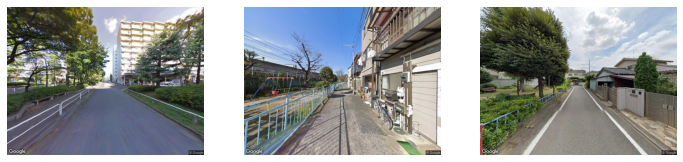

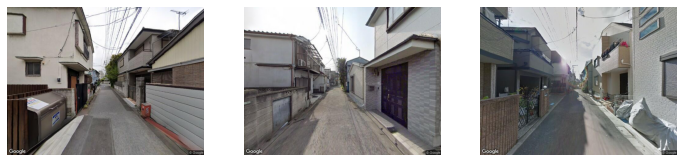

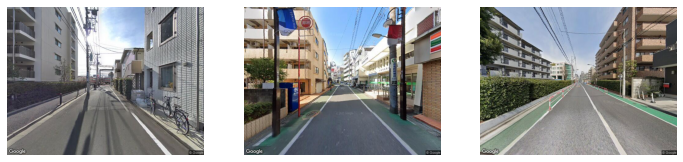

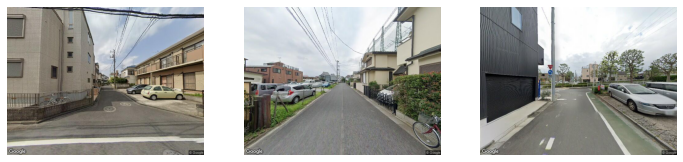

In [49]:
# now we use the pretrained model to extract the feature vectors of these imgs
model.eval() # set model to evaluate mode --> stop tracking gradients
representations = []
showsize = 128, 128
for dataset in dataset_lst:
    # for each type of the data, calculate the features mean first
    feature_vector = torch.tensor([0]*768, dtype=torch.float).to(device) # 768 dim
    fig = plt.figure(figsize=(12, 12))
    for i, shot in enumerate(dataset):
        img_path = os.path.join(data_root, shot)
        img = Image.open(img_path)
        a=fig.add_subplot(1,nshots,i+1)
        plt.imshow(img)
        plt.axis('off')
        # Preprocess image
        img = tsfm(img).unsqueeze(0)
        with torch.no_grad():
            outputs = model(img.to(device), logits=True).squeeze(0)
        # print(outputs.shape)
        feature_vector += outputs
    # print(feature_vector[0])
    feature_mean = 1/3 * feature_vector
    feature_mean_norm = F.normalize(feature_mean, dim=0)
    representations.append(feature_mean_norm.unsqueeze(0))

    # print(feature_mean_norm.shape)
    # print(feature_vector[0], feature_mean[0], feature_mean_norm[0])
print("feature vector shape:", representations[0].shape)

In [50]:
# the representation_set is [public, one, center]
# now use the same model to extract the feature vector for new data.
def extract_feature_vector(img_path, show=False):
    # feature_vector = torch.tensor([0]*768, dtype=torch.float).to(device) # 768 dim
    img = Image.open(img_path)
    if show:
        fig = plt.figure(figsize=(6,6))
        fig.add_subplot(1,1,1)
        plt.imshow(img)
    # Preprocess image
    img = tsfm(img).unsqueeze(0)
    with torch.no_grad():
        outputs = model(img.to(device), logits=True).squeeze(0)
    return F.normalize(outputs, dim=0)

In [51]:
# test with an example img
nclasses = len(representations)
print("N Classes:", nclasses)
pmatrix = torch.empty(nclasses, 768)
pmatrix = torch.cat(representations, dim=0)

N Classes: 4


## get ready for finetuning with support set

In [52]:
# define finetune data --> support set
X = []
y = []
for i, dataset in enumerate(dataset_lst):
    for fn in dataset:
        img_path = os.path.join(data_root, fn)
        X.append(extract_feature_vector(img_path).unsqueeze(0))
        y.append(i) 
        
X = torch.cat(X, dim=0).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)
print(X.shape, y.shape)

torch.Size([12, 768]) torch.Size([12])


## init cls head with proper values and configure training options

In [53]:
# the first option is to not let pretrained model weights to float.
# p(x) = softmax(w*x+b) where x is the feature vector from the feature extraction.
fc_w = pmatrix.clone().detach().requires_grad_(True) # this is recommended from pytorch doc
fc_b = torch.zeros((1,fc_w.shape[0]), dtype=torch.float, requires_grad=True)
print(fc_w.requires_grad, fc_b.requires_grad, fc_w.shape, fc_b.shape)

# torch.sum(torch.special.entr(torch.tensor([1,2,3]))) # just a test

# construct loss fn with cross-entropy and entropy regularization
def cross_entropy_regularized(output, target):
    # entropy regularization = - sum Pi * log(Pi) for Pi is the prob. for i-th class.
    
    entr =  torch.mean(torch.tensor([torch.sum(torch.special.entr(nn.Softmax(dim=0)(p))) for p in output], requires_grad=True))
    return nn.CrossEntropyLoss()(output, target) # + entr # todo: check if entr is affecting the BP
    
loss_fn = cross_entropy_regularized
# loss_fn = nn.CrossEntropyLoss()
# create a classification head with given init values
# from feature vector to 3 classes,not that we don't need softmax in torch here.
cls_head = nn.Linear(nclasses, 768)
# load the init values from the representation vectors
with torch.no_grad():
    cls_head.weight = nn.Parameter(fc_w.detach().clone())
    cls_head.bias = nn.Parameter(fc_b.detach().clone()) # --> use clone so only the values are passed into cls head
print(cls_head.bias)
print(cls_head.weight)
# construct optimizer
cls_head.to(device)
lr = 1e-1
optimizer = torch.optim.SGD(cls_head.parameters(), lr=lr)

True True torch.Size([4, 768]) torch.Size([1, 4])
Parameter containing:
tensor([[0., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[ 0.0130, -0.0477,  0.0885,  ..., -0.0289, -0.0189, -0.0014],
        [ 0.0627, -0.0666,  0.0267,  ..., -0.0157, -0.0563,  0.0540],
        [ 0.0247, -0.0359,  0.0086,  ..., -0.0554, -0.0175,  0.0028],
        [ 0.0581, -0.1000,  0.0424,  ..., -0.0381, -0.0287, -0.0212]],
       device='cuda:0', requires_grad=True)


## training step (cls head only)

In [54]:
# training loop
# make sure data is on right device
print(X.device)
# set hyperparameters
n_epochs = 2000
for epoch in range(n_epochs):
    pred = cls_head(X)
    # print(pred.shape, y.shape)
    loss = loss_fn(pred, y)
    # reset autograd
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())
    # print(pred.shape)

cuda:0
Epoch: 0 Loss: 1.219826102256775
Epoch: 100 Loss: 0.9527938365936279
Epoch: 200 Loss: 0.7591184973716736
Epoch: 300 Loss: 0.6180359721183777
Epoch: 400 Loss: 0.5136662125587463
Epoch: 500 Loss: 0.4349137544631958
Epoch: 600 Loss: 0.374264121055603
Epoch: 700 Loss: 0.32663694024086
Epoch: 800 Loss: 0.2885585129261017
Epoch: 900 Loss: 0.2576148211956024
Epoch: 1000 Loss: 0.2320982664823532
Epoch: 1100 Loss: 0.21077902615070343
Epoch: 1200 Loss: 0.1927560418844223
Epoch: 1300 Loss: 0.17735803127288818
Epoch: 1400 Loss: 0.16407747566699982
Epoch: 1500 Loss: 0.1525249034166336
Epoch: 1600 Loss: 0.1423977166414261
Epoch: 1700 Loss: 0.133457750082016
Epoch: 1800 Loss: 0.12551556527614594
Epoch: 1900 Loss: 0.11841884255409241


In [55]:
# check the detach actually works, these two sets should be different
print(cls_head.bias)
print(cls_head.weight)
print(fc_b)
print(fc_w)

Parameter containing:
tensor([[ 0.6402, -0.1491, -0.5245,  0.0333]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.2304,  0.1600,  0.6339,  ...,  0.1432,  0.0876, -0.0285],
        [ 0.3047, -0.1284, -0.1215,  ...,  0.1731, -0.4005,  0.6655],
        [-0.1973,  0.3165, -0.4231,  ..., -0.3377,  0.1348, -0.0676],
        [ 0.2815, -0.5982,  0.0768,  ..., -0.1167,  0.0566, -0.5352]],
       device='cuda:0', requires_grad=True)
tensor([[0., 0., 0., 0.]], requires_grad=True)
tensor([[ 0.0130, -0.0477,  0.0885,  ..., -0.0289, -0.0189, -0.0014],
        [ 0.0627, -0.0666,  0.0267,  ..., -0.0157, -0.0563,  0.0540],
        [ 0.0247, -0.0359,  0.0086,  ..., -0.0554, -0.0175,  0.0028],
        [ 0.0581, -0.1000,  0.0424,  ..., -0.0381, -0.0287, -0.0212]],
       device='cuda:0', requires_grad=True)


## define functions to test prediction results with no-finetuning, head-finetuning

In [64]:
# no finetuning
def make_fewshots_pred_noft(img_path, pmatrix=pmatrix):
    test_vector = extract_feature_vector(img_path, show=True)
    # print(pmatrix.shape)
    prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    print("-"*20)
    print("prediction with no-finetuning")
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")
    

In [57]:
# with cls_head finetuning
def make_fewshots_pred_ft(img_path):
    test_vector = extract_feature_vector(img_path, show=False)
    # print(pmatrix.shape)
    # prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    prediction = nn.Softmax(dim=1)(cls_head(test_vector.unsqueeze(0))).squeeze()
    print("-"*20)
    print("prediction with head-finetuning")
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")

## finetuning with BP to the pretrained vit

In [58]:
# combine vit and cls head
# make a new model
class ViT_CLS_FT(nn.Module):
    def __init__(self, pretrained_vit_body, cls_head):
        super().__init__()
        self.vit_body = pretrained_vit_body
        self.cls_head = cls_head
        # make sure model is in train mode
        self.vit_body.train()
        self.cls_head.train() 
    def forward(self, x):
        # by default the vit body will require logits=True when forward to output the logits
        x = self.vit_body(x, logits=True) # b, dim
        # normalize input x
        x = F.normalize(x, dim=1) # b, dim --> this is a trick
        # normalize weights in cls head liner layers
        with torch.no_grad():
            self.cls_head.weight.div_(torch.norm(self.cls_head.weight, dim=1, keepdim=True)) #
        x = self.cls_head(x) # b, dim
        return x

# make a new vit
vit_ft = ViT("B_16_imagenet1k", pretrained=True,
            representation_size=768,
            load_repr_layer=True,
           )
vit_ft.to(device)
# make a new cls head with preset parameters
cls_head_ft = nn.Linear(nclasses, 768)
# load the init values from the representation vectors
with torch.no_grad():
    cls_head_ft.weight = nn.Parameter(fc_w.detach().clone())
    cls_head_ft.bias = nn.Parameter(fc_b.detach().clone())
print("init values for cls head:")
print(cls_head_ft.bias)
print(cls_head_ft.weight)
# make a combined model using above two
model_ft = ViT_CLS_FT(pretrained_vit_body=vit_ft, cls_head=cls_head_ft)
model_ft.to(device)
if False:
    summary(model_ft, input_size=(3,384,384))
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(device=device)/1e9, "G")

repr size None
None True
pre_logits_size 768
Loaded pretrained weights.
init values for cls head:
Parameter containing:
tensor([[0., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[ 0.0130, -0.0477,  0.0885,  ..., -0.0289, -0.0189, -0.0014],
        [ 0.0627, -0.0666,  0.0267,  ..., -0.0157, -0.0563,  0.0540],
        [ 0.0247, -0.0359,  0.0086,  ..., -0.0554, -0.0175,  0.0028],
        [ 0.0581, -0.1000,  0.0424,  ..., -0.0381, -0.0287, -0.0212]],
       device='cuda:0', requires_grad=True)
1.62120192 G


In [59]:
# define finetune data --> support set
X = []
y = []
for i, dataset in enumerate(dataset_lst):
    for fn in dataset:
        img_path = os.path.join(data_root, fn)
        img = Image.open(img_path)
        # Preprocess image
        img = tsfm(img).unsqueeze(0)
        X.append(img)
        y.append(i) 
        
X = torch.cat(X, dim=0).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)
print(X.shape, y.shape) # b, c, h, w

batch_size = 2 # set to a small integer number.
class FTDataset(Dataset):
    def __init__(self, X, y):
        # X and y should be tensor of images and labels
        super().__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0] # size first
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
ft_dataset = FTDataset(X, y)
print(len(ft_dataset))
ft_dataloader = DataLoader(ft_dataset, batch_size=batch_size)

torch.Size([12, 3, 384, 384]) torch.Size([12])
12


In [60]:
n_epochs = 200
lr = 1e-4
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=lr)

for epoch in range(n_epochs):
    total_loss = 0
    for X, y in ft_dataloader:
        # print(torch.cuda.memory_allocated(device=device)/1e9, "G")
        pred = model_ft(X)
        # print(pred.shape, y.shape)
        loss = loss_fn(pred, y)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss_avg = total_loss.item() / (len(ft_dataset) // batch_size)
    if epoch % 5 == 0:
        print("Epoch:", epoch, "Loss:", total_loss_avg)

    # print(pred.shape)

Epoch: 0 Loss: 1.3089650472005208
Epoch: 5 Loss: 1.041300853093465
Epoch: 10 Loss: 0.9645744959513346
Epoch: 15 Loss: 0.9269537925720215
Epoch: 20 Loss: 0.9008726278940836
Epoch: 25 Loss: 0.8771855036417643
Epoch: 30 Loss: 0.8547996679941813
Epoch: 35 Loss: 0.8348996639251709
Epoch: 40 Loss: 0.8171209494272867
Epoch: 45 Loss: 0.7999579111735026
Epoch: 50 Loss: 0.783716599146525
Epoch: 55 Loss: 0.7682856718699137
Epoch: 60 Loss: 0.7538857460021973
Epoch: 65 Loss: 0.7418312231699625
Epoch: 70 Loss: 0.7297577857971191
Epoch: 75 Loss: 0.7184507846832275
Epoch: 80 Loss: 0.7088255087534586
Epoch: 85 Loss: 0.6995185216267904
Epoch: 90 Loss: 0.6901207764943441
Epoch: 95 Loss: 0.6822625796000162
Epoch: 100 Loss: 0.675019105275472
Epoch: 105 Loss: 0.6682213147481283
Epoch: 110 Loss: 0.6616244316101074
Epoch: 115 Loss: 0.6561096906661987
Epoch: 120 Loss: 0.6502034664154053
Epoch: 125 Loss: 0.6454673608144125
Epoch: 130 Loss: 0.6412796576817831
Epoch: 135 Loss: 0.636894146601359
Epoch: 140 Loss: 0

## define function to test finetuned model (vit + mlp)

In [61]:
# with cls_head finetuning
def make_fewshots_pred_ft_all(img_path):
    # test_vector = extract_feature_vector(img_path, show=True)
    # print(pmatrix.shape)
    # prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    img = Image.open(img_path)
    # Preprocess image
    img = tsfm(img).unsqueeze(0)
    prediction = nn.Softmax(dim=1)(model_ft(img.to(device))).squeeze(0)
    print("-"*20)
    print("prediction with \"vit + mlp\" finetuning")
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")
    print("-"*20)

## select any image to test results

In [69]:
test_img_path = os.path.join(data_root, "6cLJi56gTf67sG5r29DUTw.jpg")

--------------------
prediction with no-finetuning
public greenary:24.3008%
one housing:27.0536%
centerized housing:23.0171%
parking lot:25.6285%
--------------------
prediction with head-finetuning
public greenary:15.9828%
one housing:44.8451%
centerized housing:4.6667%
parking lot:34.5054%
--------------------
prediction with "vit + mlp" finetuning
public greenary:15.1839%
one housing:54.2052%
centerized housing:14.0316%
parking lot:16.5793%
--------------------


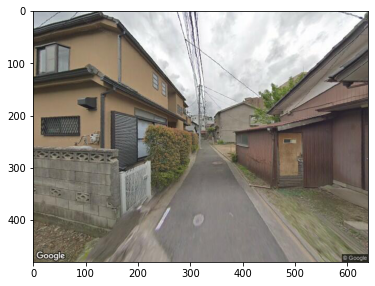

In [70]:
make_fewshots_pred_noft(test_img_path)
make_fewshots_pred_ft(test_img_path)
make_fewshots_pred_ft_all(test_img_path)

In [34]:
# save model parameters
model_ft_path = '../save_models/model_ft.pth'
cls_head_path = "../save_models/cls_head.pth"
torch.save(model_ft.state_dict(), model_ft_path)
torch.save(cls_head.state_dict(), cls_head_path)

## backup

## (optional) prepare traffic signs images into train and validation folders if needed

In [22]:
def prepare_traffic_train_val(root_path, targ_path, val_size=0.2, seed=42):
    files = glob(root_path)
    n_files = len(files)
    random.seed(seed)
    random.shuffle(files)
    os.makedirs(os.path.dirname(f"{targ_path}/train"), exist_ok=True)
    os.makedirs(os.path.dirname(f"{targ_path}/val"), exist_ok=True)
    # print(files)
    train_files, val_files = [], []
    for f in files[:int(n_files*(1-val_size))]:
        shutil.copy(f, f"{targ_path}/train")
        train_files.append(f)
    for f in files[int(n_files*(1-val_size)):]:
        shutil.copy(f, f"{targ_path}/val")
        val_files.append(f)
    return train_files, val_files

if regenerate_traffic_data:
    train_files, val_files = prepare_traffic_train_val("/mnt/data/projects/wankun01/playground/cv/rawdata/images/*", "/mnt/data/projects/wankun01/playground/cv/ViT-PyTorch/data")

In [ ]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')